# Project: Artificial neural network for Water Distribution Systems Classification

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px; height: auto; margin: 0"\>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px; height: auto; margin: 0"\>
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.6. Due: Friday, Dec 22, 2023.*

## 📝 Overview

This is the second part of Project 7, which takes place in Q2, Weeks 5 and 6. In these weeks, we'll apply optimization and machine learning techniques to design water distribution systems.

Last week, we learned how to use linear programming to solve simple systems. Later, we learned how to use a genetic algorithm to solve more complex systems. However, the hydraulic simulation inside of the genetic algorithm could be computationally slow. This week, we'll learn how to use an artificial neural network to bypass this limitation by imitating the functioning of the numerical model.

This notebook has the objective of creating a classifier model with an artificial neural network that will be used in the next notebook.

This notebook is divided into three parts. First, an introduction of how to use an artificial neural network to classify water distribution systems between between suitable (1) or not suitable (0). In the second part, you are asked a training loop function for developing such algorithm. Finally, the third part asks you to hyperoptimize the data-driven model to explore other solutions. 

Complete this assignment by the end of the session at 12:30. This means having a single notebook for your group with all code, analysis and interpretation completed. You should leave the cell outputs in the notebook.

### Working Method

We recommend that you select one group member to prepare the "master" notebooks (one for this part of the project, and one for the application). Other group members can contribute by writing and checking code or analytic expressions on their own computer or paper and sending to the "master" computer.

**Completition requirements:**

By the end of this notebook, you should have:
- Implemented all the code cells for:
  - Creating the training loop function
  - Train the data-driven model
  - Plot its training curve
  - Hyperoptimize the data-driven model
  - Assess the performance of the ANN in terms of accuracy and speed
- Interpreted the results in your own words
- Answered all the questions in the notebook

## 📔 Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:
- Numpy
- Matplotlib
- Pickle
- Scikit-learn

In [34]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

## 🔙 Background

### 💧 Water distribution systems

Water utilities rely on hydrodynamic models to properly design and control water distribution systems (WDSs). These physically-based models, such as WNTR (based on EPANET), compute the state of the system, i.e., the flow rates and pressures at all the pipes and junctions, as illustrated in Figure 1. 

Hydrodynamic models provide valuable insight into the functioning of the system. However, the computational speed of these models is often insufficient for some applications in civil engineering such as optimisation, especially in large search space problems. 

One alternative to address this issue is developing data-driven models. These models are trained using results calculated using the original model (EPANET, in this case) in multiple scenarios. The objective of the data-driven models is to estimate the output of the original model but in a shorter time.

<div>
<center><img src="./Images/Modena.png" width="700"/></center>
</div>

Figure 1. Numerical results for the water distribution system in the city of Modena, Italy.

## ⛔ Problem definition 

In this notebook, we will create a classifier of the water distribution system of the city of Modena.Your task is to create and train an alternative model of WNTR using an ANN, exemplified in Figure 2. The metamodel should predict whether a system is feasible or not while being faster to run than WNTR. 

<div>
<center><img src="./Images/ANN_image.png" width="1000"/></center>
</div>


Figure 2. Artificial neural network representation.

## 🏋🏽‍♀️ 1. Training an artificial neural network

### Load the database of examples

For the purposes of this notebook, there is an already existing database that you can use to create and train the ANN.

In [35]:
file_path = r"features_MOD.pk" 
with open(file_path, 'rb') as handle:
    features = pickle.load(handle)

file_path = r"labels_MOD.pk"
with open(file_path, 'rb') as handle:
    labels = pickle.load(handle)

We can explore the content of each of these variables. In the variable "features", we collected 10000 examples of the Modena system with random configurations of the available diameters (of the 317 pipes). These input features are related 1-1 with the "labels" variable, which indicates if an example was a suitable system (1) or not (0). For this database, being suitable means that the system is able to provide the required flow at all the nodes while satisfying the pressure constraints (minimum of 20 meters).

In [36]:
print(features.shape)
print(labels.shape)

(10000, 317)
(10000,)


### Data pre-processing

First, we split the data into training, validation, and testing sets. The training set will be used to train the model. The validation set will be used to measure the accuracy of the model in a set for which it has not been trained. The test set will be used to evaluate the performance of the model. We will use 80% of the data for training 10% for the validation, and 10% for testing.

In [37]:
X_train, X_val_test, y_train, y_val_test = train_test_split(features, labels, test_size=0.20, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50, random_state=24)

Now, we normalize the data using the MinMaxScaler from scikit-learn. This scaler transforms the data to be between 0 and 1. This is important because the ANN will be trained using the gradient descent algorithm, which is sensitive to the scale of the data. Notice that we use the training data to fit the scaler. This is important because we assume that the model only sees the training data and we do not use any of the validation or testing data.

In [46]:
scaler = MinMaxScaler()
scaler.fit(X_train)

normalized_X_train = scaler.transform(X_train)
normalized_X_val = scaler.transform(X_val)
normalized_X_test = scaler.transform(X_test)

### Training loop

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.1:</b>   
    Create a function to train a neural network (NN). There are many choices to be made when creating such a function, most are related to the bias - variance tradeoff discussed in the lectures. The outline of the function we want to create is as follows:
    
`def NN_train()`:<br>
&emsp;&emsp; For a maximum number of epochs:<br>
&emsp;&emsp;&emsp;&emsp; Permutate the data<br> 
&emsp;&emsp;&emsp;&emsp; For every minibatch:<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Collect the X & y training data<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Take a NN step (partial fit)<br> 
&emsp;&emsp;&emsp;&emsp; Compute the log-loss on the validation set<br> 
&emsp;&emsp;&emsp;&emsp; If the log-loss is the lowest:<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Save the log-loss & NN model<br> 
&emsp;&emsp;&emsp;&emsp; If log-loss has not decreased in the last X epochs<br> 
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Stop the training loop<br> 
&emsp;&emsp;&emsp;&emsp; Adapt the learning rate if necessary<br> 
&emsp;&emsp; Return NN_best, train_log_loss_list, val_log_loss_list, val_log_loss_min<br>
</div>

In [39]:
# Function to train the NN
def NN_train(NN, X_train, y_train, X_val, y_val, 
             max_epoch=1000, 
             tol=1e-6, 
             verbose=False, 
             learning_rate=0.001, 
             seed=0, 
             batchsize=50):
    
    """
    Train a neural network using mini-batch stochastic gradient descent with early stopping.

    Parameters:
    - NN (object): The neural network model to train.
    - X_train (array-like): Training input data.
    - y_train (array-like): Target values for the training data.
    - X_val (array-like): Validation input data.
    - y_val (array-like): Target values for the validation data.
    - max_epoch (int, optional): Maximum number of training epochs (default: 1000).
    - tol (float, optional): Tolerance for early stopping based on validation loss (default: 1e-6).
    - verbose (bool, optional): Whether to print training progress (default: False).
    - learning_rate (float, optional): Initial learning rate (default: 0.001).
    - seed (int, optional): Random seed for reproducibility (default: 0).
    - batchsize (int, optional): Mini-batch size for stochastic gradient descent (default: 50).

    Returns:
    - trained_model (object): The trained neural network model.
    - train_log_loss_list (list): List of training log loss values for each epoch.
    - val_log_loss_list (list): List of validation log loss values for each epoch.
    - val_log_loss_min (float): Minimum validation log loss achieved during training.
    """
    
    # Set seed 
    np.random.seed(seed)
    
    # Set up array for log-loss and improvement count for early stopping
    train_log_loss_list = []
    val_log_loss_list = [] 
    
    val_log_loss_min = 1e10
    no_improvement_count = 0
    
    # Init learning rate
    lr = learning_rate
    NN.learning_rate_init = lr
    
    NN_best = NN
    
    # Loop over iterations
    for epoch in range(max_epoch):
            
        # Set up permutation of the data
        n = X_train.shape[0]
        perm = np.random.permutation(n)
        batches_per_epoch = int(np.floor(n/batchsize))
        
        # Loop over batches
        for it in range(batches_per_epoch):
            
            # Collect current batch
            X_batch = X_train[perm[it*batchsize:(it+1)*batchsize]]
            y_batch = y_train[perm[it*batchsize:(it+1)*batchsize]]
                
            # Take step
            NN.partial_fit(X_batch, y_batch, classes=(0,1))
            
        
        y_train_hat = NN.predict(X_train)
        loss_training = log_loss(y_train, y_train_hat)
        train_log_loss_list.append(loss_training)
        
        # Compute log_loss on validation set after each epoch
        y_val_hat = NN.predict(X_val)
        loss_validation = log_loss(y_val, y_val_hat)
        val_log_loss_list.append(loss_validation)
        
        # Adapt learning rate
        # if (epoch > 0) and (epoch%lr_step==0):
        #     lr *= lr_pow
        #     NN.learning_rate_init = lr
        #     if verbose:
        #         print("Reduced learning rate to {:.4e}".format(lr))
        
        # Check if no improvement occured in last iterations
        if val_log_loss_list[-1] - val_log_loss_min > tol:
            no_improvement_count += 1
        elif val_log_loss_list[-1] < val_log_loss_min:
            val_log_loss_min = val_log_loss_list[-1]
            no_improvement_count = 0
            NN_best = NN
        
        # Exit loop when no improvement was registered during past twenty iters
        if no_improvement_count >= 100:
            print("Training stopped after {} epochs".format(epoch))
            break
        
        # Print loss (optional)
        if verbose and epoch%2==0:
            print("Epoch: {}".format(epoch),  "   Training Loss: {:.2f}".format(train_log_loss_list[epoch]), "   Validation Loss: {:.2f}".format(val_log_loss_list[epoch]))
                
    if (epoch==max_epoch-1): print("Reached max_epochs ( {} )".format(max_epoch))
    
    # Return trained network and last rmse
    return NN_best, train_log_loss_list, val_log_loss_list, val_log_loss_min

Instantiate an MLP Classifier. You can choose the number of hidden layers and the number of neurons per layer. You can also choose the activation function. You can use the default values for the rest of the parameters.

In [40]:
# Set up NN
NN = MLPClassifier(solver='adam', 
                    hidden_layer_sizes=(50, 20), 
                    activation='relu', 
                    learning_rate='constant',
                    # verbose = True,
                    alpha=1,
                    tol=1e-7,
                    warm_start=True
                    )

Use the training loop function to train the model. You can choose the number of epochs and the batch size. You can also choose the learning rate. You can use the default values for the rest of the parameters.

In [41]:
# Train NN
NN, train_log_loss_list, val_log_loss_list, val_log_loss_min = NN_train(NN, 
                                      normalized_X_train, 
                                      y_train, 
                                      normalized_X_val, 
                                      y_val, 
                                      max_epoch=500, 
                                      verbose=True, 
                                      learning_rate= 0.001, 
                                      batchsize=200)

Epoch: 0    Training Loss: 11.73    Validation Loss: 12.29
Epoch: 2    Training Loss: 11.55    Validation Loss: 12.18
Epoch: 4    Training Loss: 8.72    Validation Loss: 10.49
Epoch: 6    Training Loss: 7.33    Validation Loss: 8.76
Epoch: 8    Training Loss: 6.75    Validation Loss: 8.40
Epoch: 10    Training Loss: 6.30    Validation Loss: 7.39
Epoch: 12    Training Loss: 6.25    Validation Loss: 7.82
Epoch: 14    Training Loss: 6.13    Validation Loss: 7.42
Epoch: 16    Training Loss: 6.05    Validation Loss: 7.42
Epoch: 18    Training Loss: 6.02    Validation Loss: 7.21
Epoch: 20    Training Loss: 7.06    Validation Loss: 8.54
Epoch: 22    Training Loss: 5.81    Validation Loss: 7.32
Epoch: 24    Training Loss: 7.23    Validation Loss: 8.72
Epoch: 26    Training Loss: 6.27    Validation Loss: 8.18
Epoch: 28    Training Loss: 6.07    Validation Loss: 7.64
Epoch: 30    Training Loss: 5.61    Validation Loss: 7.46
Epoch: 32    Training Loss: 5.63    Validation Loss: 7.46
Epoch: 34    T

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 1.2:</b>   
    Plot the validation and training loss curves. Based on the shape of these curves, what can you indicate about the fitting capabilities of the model?
</div>

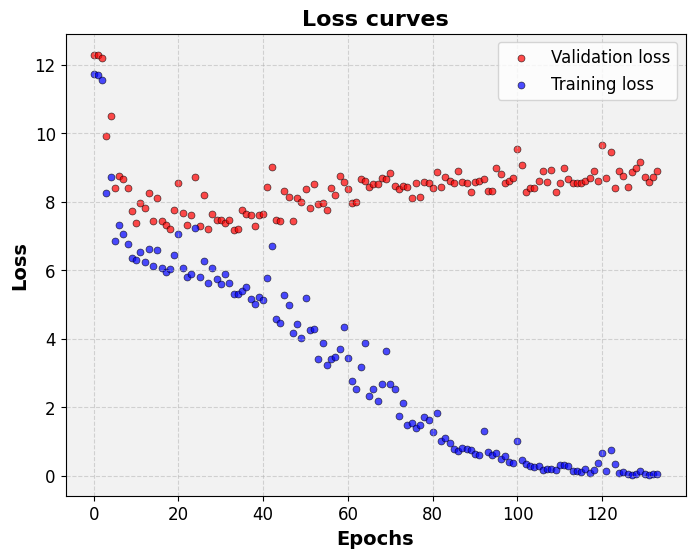

In [42]:
# Create a scatter plot with enhanced styling
plt.figure(figsize=(8, 6))  # Set the figure size

x_axis = list(range(len(train_log_loss_list)))

# Create a scatter plot
plt.scatter(x_axis, val_log_loss_list, label='Validation loss', color='red', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)
plt.scatter(x_axis, train_log_loss_list, label='Training loss', color='blue', marker='.', s=100, alpha=0.7, edgecolors='black', linewidths=0.5)

# Add labels and a legend with improved formatting
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Loss curves', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=12)

# Customize the grid appearance
plt.grid(True, linestyle='--', alpha=0.5)

# Customize the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a background color to the plot
plt.gca().set_facecolor('#f2f2f2')
plt.show()



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Solution</b><br>
<ol>
    Based on the separation of the curves, the model is overfitting. This means that the model is learning the training data too well, and it is not able to generalize to new data. This is a common problem in machine learning.
</ol>
</div>

In [43]:
NN.score(normalized_X_train, y_train)

0.99875

In [44]:
NN.score(normalized_X_val, y_val)

0.753

In [45]:
NN.score(normalized_X_test, y_test)

0.757

## 🔢 2. Hyperparameter tuning

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<b>Task 2.1:</b>   
    Create a grid-search strategy to find hyperparameters that give the best prediction on the validation set. Vary the number of layers and number of hidden units per layer. You can assume that all the hidden layers have the same number of hidden units.    

</div>

In [50]:
# define coordinate vectors for grid
layer_sizes = [20, 50, 100] 
layer_numbers = [2, 3, 4] 

# get grid for the coordinate pairs and store them in an array
val_log_loss_list = np.zeros((len(layer_sizes), len(layer_numbers)))

# loop all hidden layer sizes
for i, lsize in enumerate(layer_sizes):
    
    # loop over all numbers of hidden layers
    for j, lnumber in enumerate(layer_numbers):
    
        # get tuple of hidden layer sizes
        layers = (lsize,) * lnumber
        print("Training NN with hidden layers:  {}".format(layers))
        
        # get NN
        NN = MLPClassifier(solver='adam', hidden_layer_sizes=layers, activation='tanh')
        
        NN, _,_, val_log_loss_list[i,j], = NN_train(NN, normalized_X_train, 
                                             y_train, 
                                             normalized_X_val, 
                                             y_val, 
                                             max_epoch=20, 
                                             verbose=True, 
                                             learning_rate= 0.001,
                                             batchsize=200,
                                             )
        
        print("     Log-loss:    {:.4e}\n".format(val_log_loss_list[i,j]))


# get NN that gave lowest loss and print
min_size, min_number = np.unravel_index(np.argmin(val_log_loss_list), val_log_loss_list.shape)
print("\n\nModel with {} layers and {} neurons per layer gave lowest loss of {:.4e}".format(layer_numbers[min_number], layer_sizes[min_size], val_log_loss_list[min_size, min_number]))

Training NN with hidden layers:  (20, 20)
Epoch: 0    Training Loss: 11.71    Validation Loss: 12.29
Epoch: 2    Training Loss: 11.34    Validation Loss: 12.18
Epoch: 4    Training Loss: 8.34    Validation Loss: 10.34
Epoch: 6    Training Loss: 7.21    Validation Loss: 9.08
Epoch: 8    Training Loss: 6.47    Validation Loss: 8.47
Epoch: 10    Training Loss: 6.35    Validation Loss: 8.07
Epoch: 12    Training Loss: 7.19    Validation Loss: 8.94
Epoch: 14    Training Loss: 5.98    Validation Loss: 7.71
Epoch: 16    Training Loss: 5.92    Validation Loss: 7.21
Epoch: 18    Training Loss: 5.86    Validation Loss: 7.53
Reached max_epochs ( 20 )
     Log-loss:    7.2087e+00

Training NN with hidden layers:  (20, 20, 20)
Epoch: 0    Training Loss: 11.73    Validation Loss: 12.29
Epoch: 2    Training Loss: 11.62    Validation Loss: 12.25
Epoch: 4    Training Loss: 8.34    Validation Loss: 9.41
Epoch: 6    Training Loss: 6.67    Validation Loss: 8.04
Epoch: 8    Training Loss: 6.20    Validatio

Let's use our test data to visualize our best-performing model and test its predictive capabilities. First, re-initialize & train the model with the optimal hyperparameters.


In [52]:
# Set up NN
layers = (layer_sizes[min_size],) * layer_numbers[min_number]
NN = MLPClassifier(solver='adam', hidden_layer_sizes=layers, activation='tanh')

# train NN
NN, _, _, _ = NN_train(NN, normalized_X_train, y_train, normalized_X_val, y_val, max_epoch=100, verbose=True, learning_rate=0.001, batchsize=200)

Epoch: 0    Training Loss: 11.73    Validation Loss: 12.29
Epoch: 2    Training Loss: 11.62    Validation Loss: 12.25
Epoch: 4    Training Loss: 8.34    Validation Loss: 9.41
Epoch: 6    Training Loss: 6.67    Validation Loss: 8.04
Epoch: 8    Training Loss: 6.20    Validation Loss: 7.32
Epoch: 10    Training Loss: 6.05    Validation Loss: 7.32
Epoch: 12    Training Loss: 5.91    Validation Loss: 7.10
Epoch: 14    Training Loss: 5.80    Validation Loss: 7.06
Epoch: 16    Training Loss: 5.61    Validation Loss: 7.17
Epoch: 18    Training Loss: 6.20    Validation Loss: 7.39
Epoch: 20    Training Loss: 5.76    Validation Loss: 7.28
Epoch: 22    Training Loss: 5.62    Validation Loss: 7.35
Epoch: 24    Training Loss: 5.18    Validation Loss: 6.78
Epoch: 26    Training Loss: 5.47    Validation Loss: 7.53
Epoch: 28    Training Loss: 5.24    Validation Loss: 7.46
Epoch: 30    Training Loss: 5.26    Validation Loss: 7.53
Epoch: 32    Training Loss: 4.67    Validation Loss: 7.10
Epoch: 34    Tr

## 🎯 3. Model assessment

### Accuracy

We can test the model's accuracy on the test dataset.

In [53]:
NN.score(normalized_X_test, y_test)

0.741

### Speed

We can calculate the time per scenario that the model takes.

Run this cell multiple times and you obtain different results. The time that the model takes depends on the speed of your computer and the number of processes that are running at the same time (among others). 

In [54]:
start_time = time.time()
y_pred_test = NN.predict(X_test)
total_time = time.time() - start_time

num_test_sims = len(y_pred_test)

data_driven_exec_time_per_sim = total_time/num_test_sims
print(f'Data-driven model took {data_driven_exec_time_per_sim:.7f} seconds for {num_test_sims} scenarios')

Data-driven model took 0.0000061 seconds for 1000 scenarios


Considering that the original model can take up to 0.04 seconds per scenario, we can estimate the potential gain in speed-up. (Speed-up = original_time/Data-driven_model_time)


In [55]:
original_time_per_sim = 0.04

speed_up = np.round(original_time_per_sim/data_driven_exec_time_per_sim, 2)
print('The data-driven model is', speed_up,'times faster than EPANET per scenario.')

The data-driven model is 6533.69 times faster than EPANET per scenario.


## 💾 4.  Save the classifier and the scaler

In [ ]:
with open('classifier_MOD_Sklearn.p', 'wb') as handle:
    pickle.dump(NN, handle)

In [ ]:
with open('normalizer_MOD_Sklearn.p', 'wb') as handle:
    pickle.dump(scaler, handle)

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.